In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import pandas as pd
import json
import numpy as np
import pickle
from modules.functions import pymatgen_comp
from modules.trained_models import get_uts_without_grain
import matplotlib.pyplot as plt

In [3]:
el_list_loc = 'misc/element_order_uts.pkl'
with open(el_list_loc,'rb') as fid:
    el_list = pickle.load(fid)

In [4]:
def to_vec(pymatgen_comp, el_list = el_list):
    vec_arr = np.zeros((1,len(el_list)))
    for i in pymatgen_comp.get_el_amt_dict().keys():
        ind = np.argwhere(np.array(el_list) == i)
        vec_arr[:,ind] = pymatgen_comp.get_atomic_fraction(i)
    return vec_arr

In [5]:
with open('misc/starting_comp.json','r') as fid:
    json_dict = json.load(fid)

In [6]:
import pymatgen.core as mg
def decode(vec, elem_list, thresh=0.03):
    vec[vec<thresh] = 0
    vec /= vec.sum()
    comp = ''
    for i, x in enumerate(vec):
        if x >= thresh:
            comp += elem_list[i] + '{:.2f} '.format(x)
    return mg.Composition(comp)
decode(np.array(json_dict['start_comp']), el_list).reduced_formula

'Hf0.18Zr0.07Ti0.07Nb0.06Cr0.2Mo0.06W0.36'

In [7]:
to_consider = ['Nb','Mo','Zr','Ti','V','W','Hf','Cr','Ta']
at_frac = np.array(json_dict['start_comp']).reshape(1,-1)
w_ind = np.argwhere(np.array(el_list) == 'W').item()
w_content = np.array(at_frac)[:,w_ind].item()
to_reduce_by = 0.0005
best_cand = []
best_cand_uts = []
at_frac_or = at_frac.copy()
while w_content >= json_dict['end_w_content']:
    w_content -= to_reduce_by
    uts_list = []
    comp_list = []
    for i,af in enumerate(at_frac.flatten()):
        at_frac_new = at_frac.copy()
        at_frac_new[:,w_ind] = w_content
        if i!=w_ind and el_list[i] in to_consider:
            at_frac_new[:,i] = at_frac_new[:,i]+to_reduce_by
            if np.round(np.sum(at_frac_new),2) == 1:
                comp_list.append(at_frac_new)
                uts_temp = get_uts_without_grain(np.array(at_frac_new).reshape(1,-1)).item()
                uts_list.append(uts_temp)
    highest = np.argmax(np.array(uts_list))
    best_cand.append(comp_list[highest])
    best_cand_uts.append(uts_list[highest])
    at_frac = comp_list[highest] 


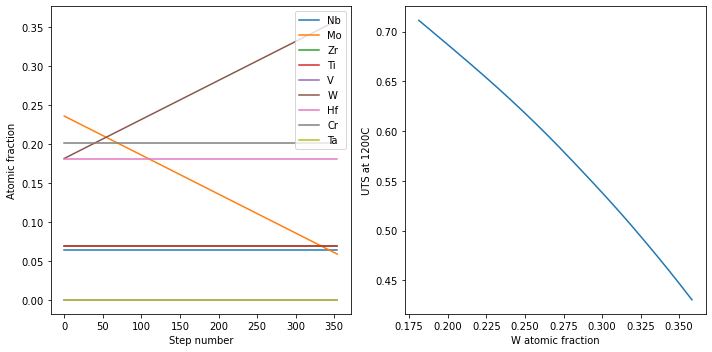

In [8]:
best_cand = np.array(best_cand).reshape(len(best_cand),-1)
fig,ax = plt.subplots(1,2,figsize=(10,5))
to_consider = ['Nb','Mo','Zr','Ti','V','W','Hf','Cr','Ta']
for el in to_consider:
    i = np.argwhere(np.array(el_list) == el).item()
    ax[0].plot(best_cand[:,i][::-1],label = el_list[i])

ax[0].set_xlabel('Step number')
ax[0].set_ylabel('Atomic fraction')
ax[0].legend()

ax[1].plot(best_cand[:,w_ind], best_cand_uts)
ax[1].set_ylabel('UTS at 1200C')
ax[1].set_xlabel('W atomic fraction')

plt.tight_layout()

In [9]:
forward_dict = {
    'forward':{
        'best_cands':best_cand[::-1].tolist(),
        'best_cand_uts':best_cand_uts[::-1],
        'w_content':best_cand[:,w_ind][::-1].tolist()
    }
}

In [10]:
with open('results.json','r') as fid:
    temp_dict = json.load(fid)

In [11]:
results_dict = temp_dict|forward_dict
with open('results.json','w') as fid:
    json.dump(results_dict,fid)